# <img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 11 - Pytorch NN module and optimizers
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

In this lecture: 

- Methods and attributes for a PyTorch ``nn.Module`` object.
- Parametric model example using PyTorch ``nn.Module``. 
- PyTorch optimizers for training ``nn.Module`` object.
- Recipe for using a PyTorch optimizer in a basic machine learning training loop.


To recap what we have been doing for the last 2 weeks. We have: 

- Dataset $\mathcal{D}=\{(x_i, y_i)\}_{i=0}^{N-1}$
- Model $f_\theta(x)$ with learnable parameters $\theta$
- Loss function $\ell(f_\theta(x_i), y_i)$
- Learning algorithm to update parameter values using loss function, e.g. gradient descent


Example: 
    
In logistic regression we have: 
    
* Dataset $\mathcal{D}=\{(x_i, y_i)\}_{i=1}^{N}$, where $x_i\in\mathbb{R}^3$ and $y_i\in\{0, 1\}$.
* Model $f_\theta(x)$ where
  $$
  f_\theta(x) = \mathbf{Pr}\{y_i=1|x_i\}=\frac{1}{1+e^{-(w^\top x_i+b)}}
  $$
  and $\theta=\{w, b\}\in\mathbb{R}^4$.
* The loss function may be binary cross-entropy $\ell_{\textrm{bce}}(f_\theta(x_i), y_i)$
  $$
  \ell_{\textrm{bce}}(f_\theta(x_i), y_i)=-\left[(1-y_i)\log(1-f_\theta(x_i))+y_i\log(f_\theta(x_i))\right]
  $$
* By chain rule (i.e. backpropagation), we may obtain $\frac{\partial \ell_{\textrm{bce}}}{\partial w}$ and $\frac{\partial \ell_{\textrm{bce}}}{\partial b}$ and use gradient descent with step-size or **learning rate** $\alpha$ to find a good solution for the parameters over the dataset.    

## Brief review of objects and classes

* **Class:** A collection of attributes and functions (methods) providing an interface to distinct instances and applications of these common attributes and functions.
* **Object:** An instance of a class that can perform the desired functionalities which are defined in the class. Separate objects of a class may apply the functionality of a class differently. For example, a "Fruit" class may have attributes that can helpfully distinguish between apple and banana objects which are instances of the "Fruit" class.
* **self:** The ``self`` identifier represents the instance of the class. By using the **self** keyword we can access the **attributes** and **methods** of the class in python or assign attributes of the given object within the class definition. 
* **\_\_init\_\_ :** The ``__init__`` method is a reseved method in Python classes. It is known as the **constructor** in object oriented programming . This method called when an object is created from the class and it allow the class to initialize the attributes of a class.

## ``nn.Module`` class

The [``nn.Module`` class](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) is the universal **base class** for neural networks, and more broadly trainable models, in PyTorch found within the ``torch.nn`` package, i.e. ``torch.nn.Module``. We create our own models by **inheriting** this base class and implementing the necessary methods for the class. There are two methods which must be implemented: ``__init__`` and ``forward``.

The ``__init__`` method specifies the constructor and thus how every instance of this module must be initialized the ``__init__`` method must first call ``super().__init__()`` to call the constructor of the base ``nn.Module`` class (and thus access all the helpful attributes and methods within). The ``forward`` method implements how the model processes input data for its **forward pass**.

As an example ``nn.Module`` class. Consider a class for implementing third-order polynomial regression. In this case, we have
$$
f_\theta(x) = ax^3+bx^2+cx+d
$$
and $\theta=\{a, b, c, d\}$. The corresponding ``nn.Module`` class may be written as follows.

In [2]:
import torch
import torch.nn as nn

class ThirdOrderPolynomial(nn.Module):
    def __init__(self):
        '''
        Specify the learnable parameters: a, b, c, d
        '''
        super().__init__() # call nn.Module constructor first
        self.a = nn.Parameter(torch.rand(1))
        self.b = nn.Parameter(torch.rand(1))
        self.c = nn.Parameter(torch.rand(1))
        self.d = nn.Parameter(torch.rand(1))

    def forward(self, x):
        '''
        Implement f(x).
        '''
        f_x = self.a*x**3 + self.b*x**2 + self.c*x + self.d
        return f_x

# create ThirdOrderPolynomial object
my_model = ThirdOrderPolynomial()
# print model parameters
print(my_model.a)
print(my_model.b)
print(my_model.c)
print(my_model.d)
x_input = torch.tensor([1])
prediction = my_model(x_input)
print(prediction)

Parameter containing:
tensor([0.2886], requires_grad=True)
Parameter containing:
tensor([0.9114], requires_grad=True)
Parameter containing:
tensor([0.5586], requires_grad=True)
Parameter containing:
tensor([0.8617], requires_grad=True)
tensor([2.6203], grad_fn=<AddBackward0>)


Important things to note: 

- ``self`` parameter must be used to access class attributes and methods. 
    - When is ``self`` not needed? 
- Model parameters may be specified by wrapping a tensor in the ``nn.Parameter`` class.
 - The ``nn.Module`` class automatically collects all learnable paramters in the ``.parameters()`` attribute. This makes scaling our models and learning algorithms dramatically easier!

In lecture notes: 
    
- ``self`` is not needed for static methods (normal functions defined inside a class for organizational purposes.
- 

In [3]:
learnable_parameters = my_model.parameters()
print(learnable_parameters)
for p in learnable_parameters:
    print(p)

<generator object Module.parameters at 0x10c634900>
Parameter containing:
tensor([0.2886], requires_grad=True)
Parameter containing:
tensor([0.9114], requires_grad=True)
Parameter containing:
tensor([0.5586], requires_grad=True)
Parameter containing:
tensor([0.8617], requires_grad=True)


## Example: Logistic Regression Module

Implement a logistic regression model class for inputs $x_i\in\mathbb{R}^N$ and include a bias term. Recall that 
$$
f_\theta(x)=\mathbf{Pr}\{y=1|x\}=\frac{1}{1+e^{-(w^\top x+b)}}.
$$

/var/folders/r5/0w7y2nzn6z519vv67rcw3ffr0000gn/T/ipykernel_48708/2244924915.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_values = [my_logreg(torch.tensor(x_values[i].view(-1, 1))) for i in range(L)]


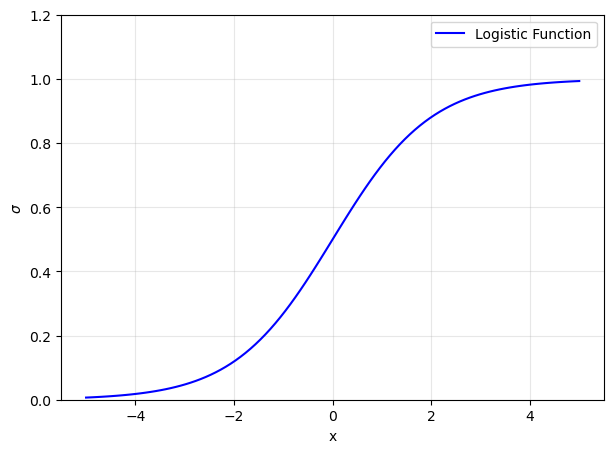

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegression(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.w = nn.Parameter(torch.ones(N))
        self.b = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        #x = x.view(-1, 1)
        return 1/(1+torch.exp(-(self.w@x+self.b)))

N = 1
my_logreg = LogisticRegression(N)
x = torch.randn(N)
y = my_logreg(x)

# Plot both on the same figure
L = 100
x_values = torch.linspace(-5, 5, L)
with torch.no_grad():
    y_values = [my_logreg(torch.tensor(x_values[i].view(-1, 1))) for i in range(L)]
plt.figure(figsize=(7,5))
plt.plot(x_values.detach().numpy(), y_values, 'b', label="Logistic Function")

# Axis labels, legend, grid, etc.
plt.xlabel('x')
plt.ylabel('$\sigma$')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim([0, 1.2])  # Adjust as needed
plt.show()
#plt.savefig("img/log_ce_loss_plot.png")

## Loss functions

Also within the ``torch.nn`` package is a variety of [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) implemented as classes. Thus, we may create instances of these loss functions with varying attributes that may be called while training models. Most of the functions are simply wrapper functions for functions within ``torch.nn.functional``; however, they provide a helpful interface to simplify training code.

For example, the ``nn.MSELoss`` class implements mean squared error loss with an attribute to specify the "reduction" of the loss. This reduction parameter allows us to specify if we want the squared errors to be summed, averaged, or left as a tensor of squared errors. In the latter case, we may use this to only incorporate select squared errors, i.e. masking or re-weighting, for certain applications.

In general, for model object named ``model``, inputs named ``inputs``, ground-truths named ``targets``, and loss function object named ``criterion``, we may succinctly compute the current loss for our model as follows.

``predictions = model(inputs)``

``loss = criterion(predictions, targets)``

The result of such a loss function can then act as the seed node from which we backpropagate for model training. Similarly, we may implement a custom loss function ourself (as an nn.Module class or as a regular function). 

In [5]:
import torch
import torch.nn as nn

criterion_mean = nn.MSELoss(reduction='mean')
criterion_sum = nn.MSELoss(reduction='sum')
criterion_none = nn.MSELoss(reduction='none')

x = torch.zeros(4)
y = torch.ones(4)

print(criterion_mean(x, y))
print(criterion_sum(x, y))
print(criterion_none(x, y))

tensor(1.)
tensor(4.)
tensor([1., 1., 1., 1.])


## ``torch.optim`` package

We now know how to create a PyTorch model and how to apply a loss function to a dataset and model outputs. We have previously seen how to use the ``.backward()`` method to initiate backpropagation. However, we found it quite tedious to update each individual parameter by gradient descent and to clear those gradients each iteration.

The [``torch.optim`` package](https://pytorch.org/docs/stable/optim.html) contains many helpful optimizers, i.e. learning algorithms, and other useful interfaces to simplify the parameter updating process. The simplest optimizer in the ``torch.optim`` package is the ``optim.SGD``, which implements **stochastic gradient descent** (SGD). Also known as mini-batch gradient descent, SGD implements gradient descent except only computes the gradient over a random subset, or mini-batch, of the data. Thus, the computed gradient depends on a stochastic sample of the dataset. If the **batch size** for SGD is the entire dataset, then SGD simply becomes ordinary gradient descent.

**Pros:**
* Faster than gradient descent
* Noisier gradients from random subsets can help exit local minima

**Cons:**
* Can have slower convergence due to noisy gradients

### Momentum and Weight Decay

The [``optim.SGD`` optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) implements other helpful features aside from basic gradient descent including **momentum** and **weight decay**. As mentioned above, the gradients from SGD may be noisy and susceptible to random outliers. Momentum is one way to smooth out gradient descent updates by incorporating a moving average of previous gradients. Let $\mu\in[0, 1)$ be the momentum parameter, $g^{(k)}$ be the gradient over the batch in iteration $k$, and $\theta^{(k)}$ be the model parameters as iteration $k$. The learning algorithm for SGD with momentum and learning rate $\alpha$ is then

$$
\begin{align}
G^{(k)} &= g^{(k)} + \mu G^{(k-1)}\\
\theta^{(k+1)} &= \theta^{(k)} - \alpha G^{(k)}.
\end{align}
$$

Thus, the gradients become as exponential moving average of previous gradients where all previous gradients contribute a weight of $\mu^{k-m}$ from step $m$. Popular choices of $\mu$ are larger values such as $0.9$ and $0.99$ so that the exponential moving average does not vanish too quickly.

The weight decay parameter implements the same $L_2$ regularization we saw with linear regression. For loss function $\ell(f_\theta(x), y)$ and weight decay parameter $\lambda$, the effective total loss function used for backpropagation is given by

$$
\ell_{\textrm{total}} = \ell(f_\theta(x), y)+\frac{\lambda}{2}\lVert\theta\rVert_2^2.
$$
Thus, an additional component of $\lambda\theta$ is added to the gradient. The purpose of weight decay is to encourage model parameters to not be too large and thus prone to overfitting and dangerous outlier behavior. Common choices of weight decay vary by model type and size, however, a small value like $10^{-5}$ is often a safe starting point. Other parameters exist within the ``optim.SGD`` class, but these two are the most important to explain.

The ``torch.optim`` package contains [many other popular optimizers](https://pytorch.org/docs/stable/optim.html#algorithms), such as Adagrad and Adam, which are popular **adaptive gradient** methods where per-layer learning rates are automatically tuned during training. For now, we will focus on applying SGD.

To initialize the SGD optimizer, and most other optimizers, we need to give the optimizer:
* A generator instance for the model parameters, i.e. call ``model.parameters()`` from our ``nn.Module`` object instance.
* Learning rate
* Momentum parameter (optional)
* Weight decay (optional)
* and other optional parameters for fancier learning algorithms

In [6]:
import torch

optimizer = torch.optim.SGD(my_logreg.parameters(), lr=1e-3, momentum=0.99, weight_decay=1e-4)

### Learning Rate Adjustments

- Lastly, the overall learning rate for a learning algorithm is commonly adjusted in practice. 
 
- The most common method for this is to simply lower the learning rate by some factor whenever the loss function or validation performance appears to plateau. 

- The intuition for this is that a smaller learning rate allows us to more carefully descend into the current local minimum the model is converging to and hopefully provide additional modest improvements in performance. 

- The ``torch.optim`` package provides helpful learning rate **scheduler** [interfaces](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) where different learning rate policies may be implemented, e.g. after some number of gradient descent updates, after loss plateaus, or different policies for variably increasing or decreasing the learning rate. We will not worry about these for now, but they are important to point out within this package.

## A PyTorch training loop

Finally, we have all the necessary ingredients to create a PyTorch training loop! This training loop, while basic, forms the core of any model training code within PyTorch. Before executing the training loop, we need to ensure a few things are set:
* The model is instantiated/initialized.
* The dataset is prepared.
* The loss function and optimizer are instantiated.

With these in hand, the training loop takes on the following basic cycle for optimizer named ``optimizer`` and loss function named ``criterion``:
1. Zero out the gradients using the optimizer using ``optimizer.zero_grad()``.
2. Pass the current batch or entire dataset to the model to generate predictions.
3. Calculate loss from ``criterion``.
4. Backpropagate from loss value and perform gradient descent update by ``optimizer.step()``
5. (Optional) Perform any desired logging, e.g. loss values, performance metrics, etc.

And that's it! Let's get some practice with a toy dataset.

torch.Size([100, 2]) torch.Size([100])


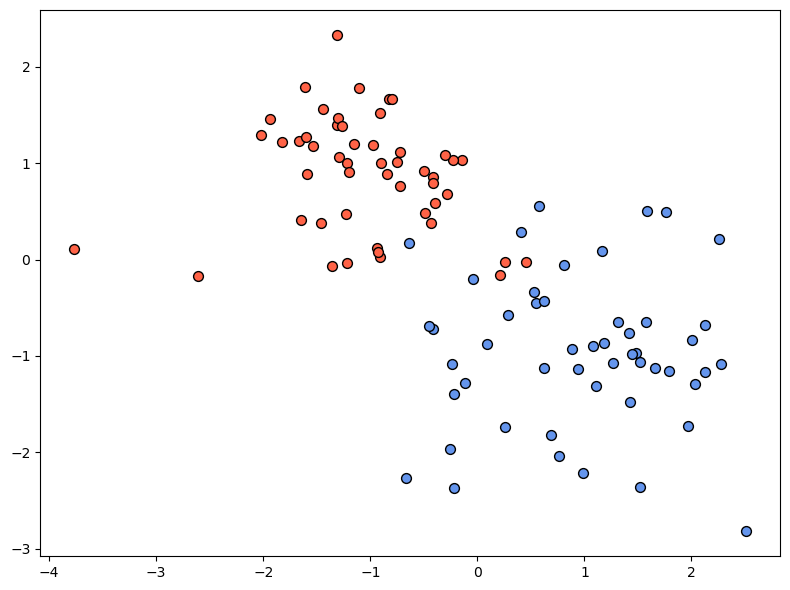

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# plotting utility function to visualize model proabilities of positive class
def plot_model_probs(model, plus_class, negative_class):
    x = torch.linspace(-4, 4, 100)
    y = torch.linspace(-4, 4, 100)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    meshgrid_inputs = torch.stack((X.flatten(), Y.flatten()), dim=1).unsqueeze(-1)
    with torch.no_grad():
        meshgrid_outputs = logreg_model(meshgrid_inputs)

    plt.figure(figsize=(8, 6))
    plt.contourf(X.numpy(), Y.numpy(), meshgrid_outputs.reshape(100, 100).numpy(), cmap='RdBu_r', levels=100)
    plt.colorbar()
    plt.title('Probability of positive class')
    plt.scatter(plus_class[:, 0].numpy(), plus_class[:, 1].numpy(), color='tomato', s=50, edgecolor='black')
    plt.scatter(negative_class[:, 0].numpy(), negative_class[:, 1].numpy(), color='cornflowerblue', s=50, edgecolor='black')
    plt.tight_layout()

# compute classification accuracy
def model_accuracy(model, input_data, labels):
    predictions = model(input_data.unsqueeze(-1)).squeeze(-1)
    positive_preds = predictions >= 0.5
    negative_preds = predictions < 0.5
    n_correct = torch.sum(positive_preds*labels)+torch.sum(negative_preds*(1-labels))
    return n_correct/len(labels)

# prepare dataset
N = 50 # 50 points per class
plus_class = 0.75*torch.randn(N, 2) + torch.tensor([-1, 1])
negative_class = 0.75*torch.randn(N, 2) + torch.tensor([1, -1])
input_data = torch.cat((plus_class, negative_class), dim=0)
labels = torch.cat((torch.ones(N), torch.zeros(N)))
print(input_data.shape, labels.shape)
plt.figure(figsize=(8, 6))
plt.scatter(plus_class[:, 0].numpy(), plus_class[:, 1].numpy(), color='tomato', s=50, edgecolor='black')
plt.scatter(negative_class[:, 0].numpy(), negative_class[:, 1].numpy(), color='cornflowerblue', s=50, edgecolor='black')
plt.tight_layout()

Model accuracy: 0.520


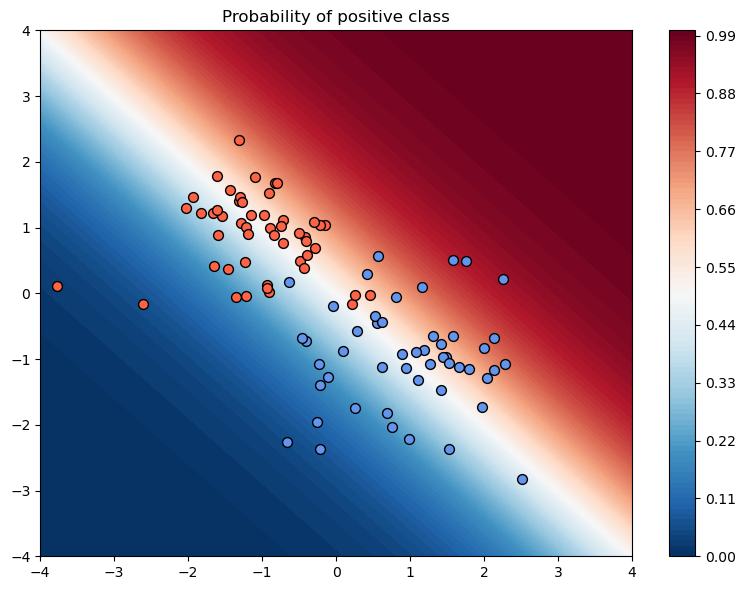

In [8]:
# setup before training loop
# set up model
logreg_model = LogisticRegression(2)

# loss function and optimizer
criterion = nn.BCELoss(reduction='mean') # binary cross-entropy loss, use mean loss
lr = 1e-2 # learning rate
optimizer = torch.optim.SGD(logreg_model.parameters(), lr=lr) 

# plotting utility, initial model performance (before learning!)
plot_model_probs(logreg_model, plus_class, negative_class) # initial 
print('Model accuracy: {:.3f}'.format(model_accuracy(logreg_model, input_data, labels)))

## Example: Varying training parameters
In the above example, we chose a learning rate of $\alpha=10^{-2}$, used no momentum, used no weight decay, and trained the model for 200 iterations.

a) Compare the results of training with and without momentum, keeping the learning rate and number of iterations fixed.

**Setting**:
* $\mu=0.99$

**Observations**:
* The loss values are lower and the accuracy improves faster to the best possible accuracy.

b) Now add weight decay and observe the changes to the training loss and accuracy.

**Setting**:
* $\lambda=0.4$
  
**Observations**:
* The boundary is very gradual while the loss and accuracy values oscillate (and are negatively correlated). This is because as the model performs better, the weights become larger. Then, the weight decay component of the loss dominates and reduces the weights and degrades accuracy. And so on!

**Setting**:
* $\lambda= 10^{-2}$

**Observations**:
* The boundary is a bit more gradual than without weight decay while retaining the same accuracy with slightly higher loss values (less overfitted).

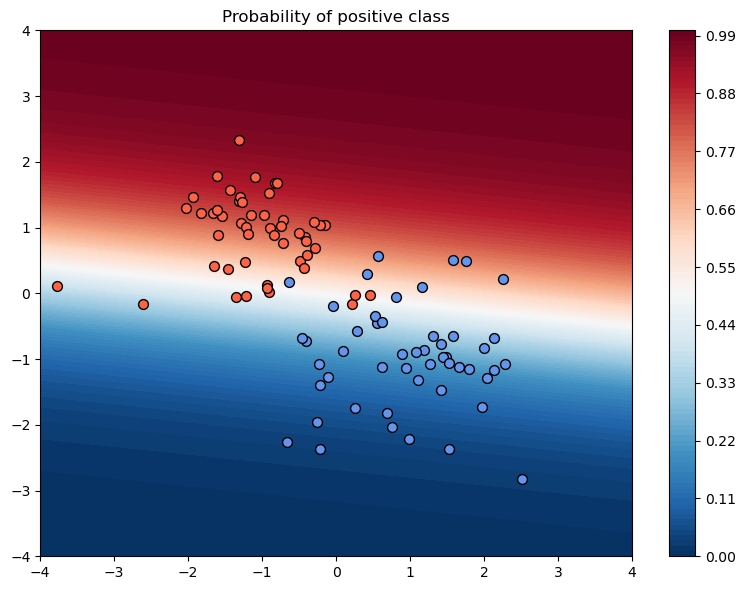

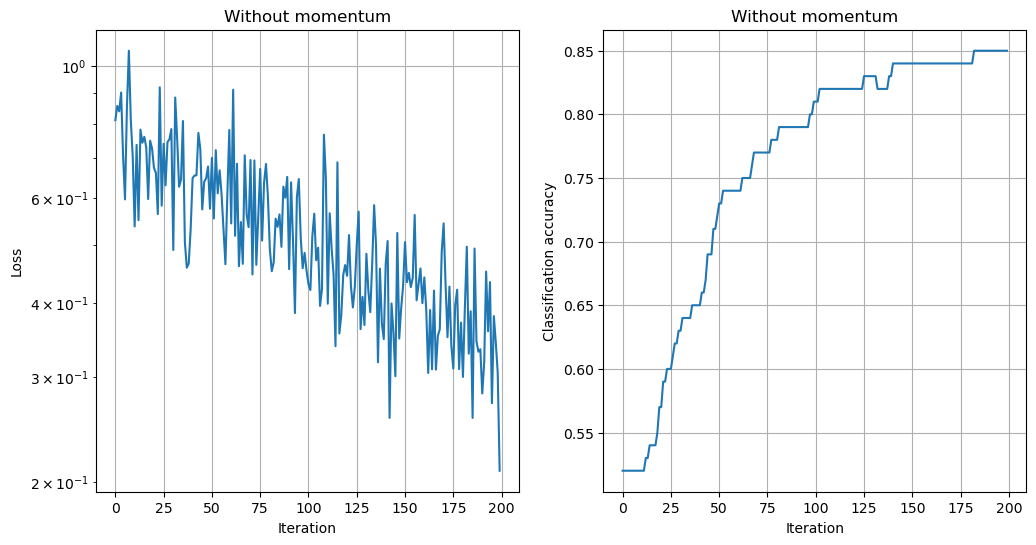

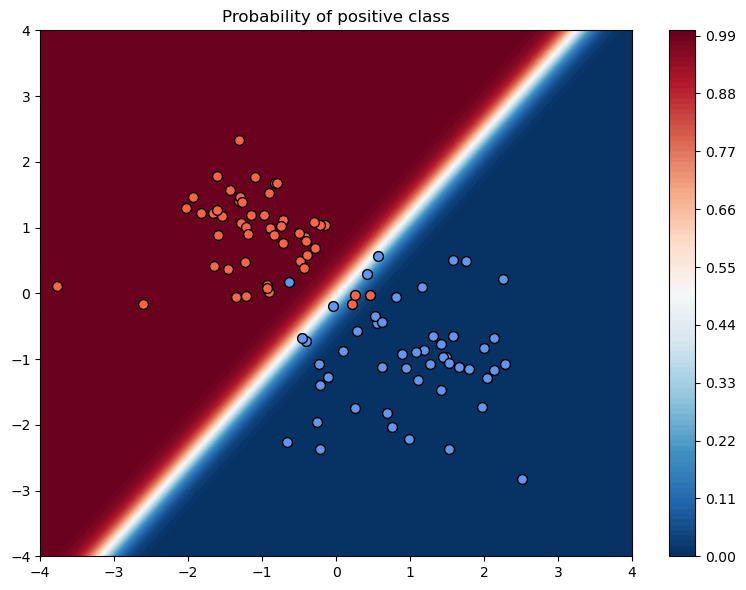

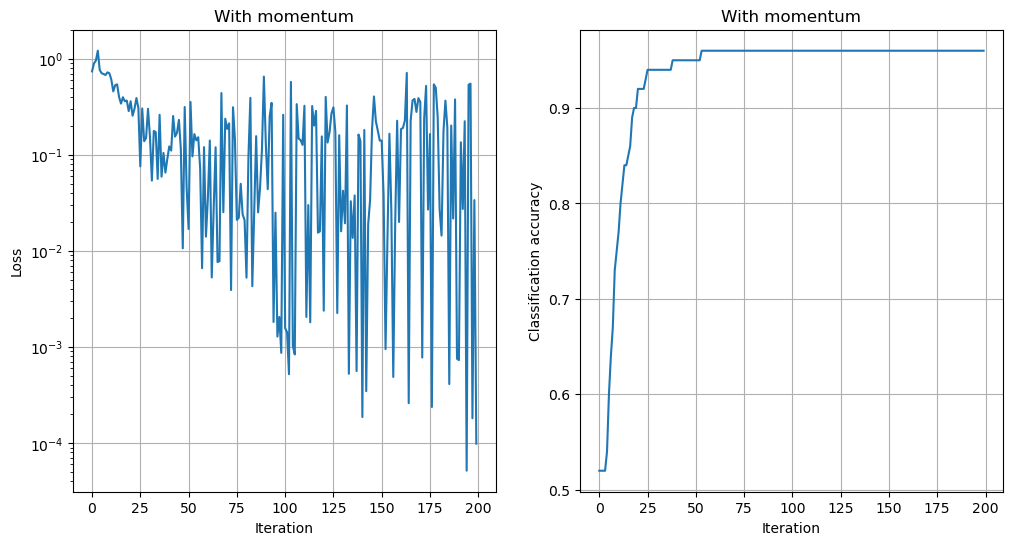

In [17]:
# Part a)
# loss function and optimizer
criterion = nn.BCELoss(reduction='mean') # binary cross-entropy loss, use mean loss
lr = 1e-2 # learning rate

# without momentum
plot_probs = True
logreg_model = LogisticRegression(2)
optimizer = torch.optim.SGD(logreg_model.parameters(), lr=lr) 
# training loop
n_iter = 200
batch_size = 16
loss_values, accuracies = [], []
for n in range(n_iter):
    # zero out gradients
    optimizer.zero_grad()
    # sample random batch and pass to model
    batch_indices = np.random.choice(np.arange(len(labels)), size=batch_size)
    input_batch = input_data[batch_indices].unsqueeze(-1) # make dimensions match for matrix multiplication
    label_batch = labels[batch_indices]
    predictions = logreg_model(input_batch).squeeze(-1) # make dimensions match for loss function
    # calculate loss
    loss = criterion(predictions, label_batch)
    # backpropagate and update
    loss.backward()
    optimizer.step()
    # logging
    loss_values.append(loss.item())
    accuracies.append(model_accuracy(logreg_model, input_data, labels))
# plot model probabilities
if plot_probs:
    plot_model_probs(logreg_model, plus_class, negative_class)
    plt.savefig("./img/classification_no_momentum.png")

# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Without momentum')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('Without momentum')
plt.xlabel('Iteration')
plt.ylabel('Classification accuracy')
plt.savefig("./img/lossacc_no_momentum.png")

# with momentum
plot_probs = True
logreg_model = LogisticRegression(2) # re-initialize model
optimizer = torch.optim.SGD(logreg_model.parameters(), lr=lr, momentum=0.99) 
# training loop
n_iter = 200
batch_size = 16
loss_values, accuracies = [], []
for n in range(n_iter):
    # zero out gradients
    optimizer.zero_grad()
    # sample random batch and pass to model
    batch_indices = np.random.choice(np.arange(len(labels)), size=batch_size)
    input_batch = input_data[batch_indices].unsqueeze(-1) # make dimensions match for matrix multiplication
    label_batch = labels[batch_indices]
    predictions = logreg_model(input_batch).squeeze(-1) # make dimensions match for loss function
    # calculate loss
    loss = criterion(predictions, label_batch)
    # backpropagate and update
    loss.backward()
    optimizer.step()
    # logging
    loss_values.append(loss.item())
    accuracies.append(model_accuracy(logreg_model, input_data, labels))
# plot model probabilities
if plot_probs:
    plot_model_probs(logreg_model, plus_class, negative_class)
    plt.savefig("./img/classification_w_momentum.png")
# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('With momentum')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('With momentum')
plt.xlabel('Iteration')
plt.ylabel('Classification accuracy')
plt.savefig("./img/lossacc_w_momentum.png")

<table>
    <tr>
        <td><img src="./img/classification_no_momentum.png" alt="Image 1" width="800"></td>
        <td><img src="./img/classification_w_momentum.png" alt="Image 2" width="800"></td>
    </tr>
    <tr>
        <td><img src="./img/lossacc_no_momentum.png" alt="Image 3" width="800"></td>
        <td><img src="./img/lossacc_w_momentum.png" alt="Image 4" width="800"></td>
    </tr>
</table>

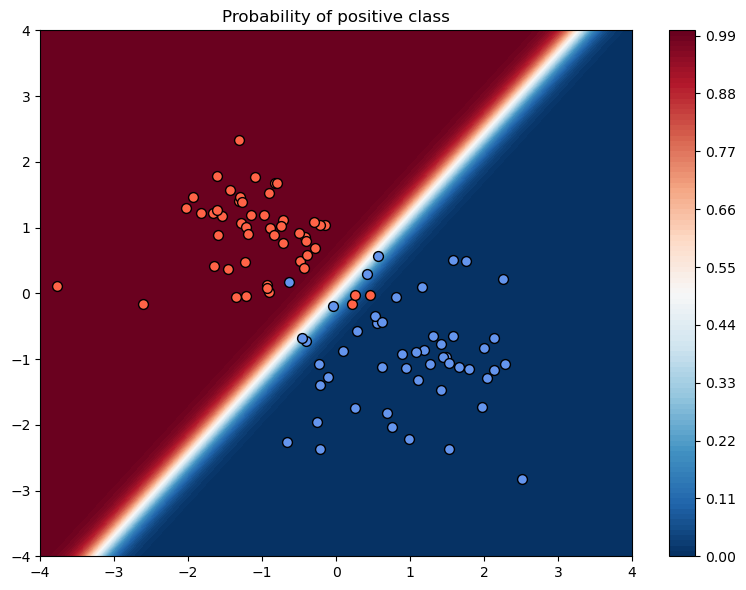

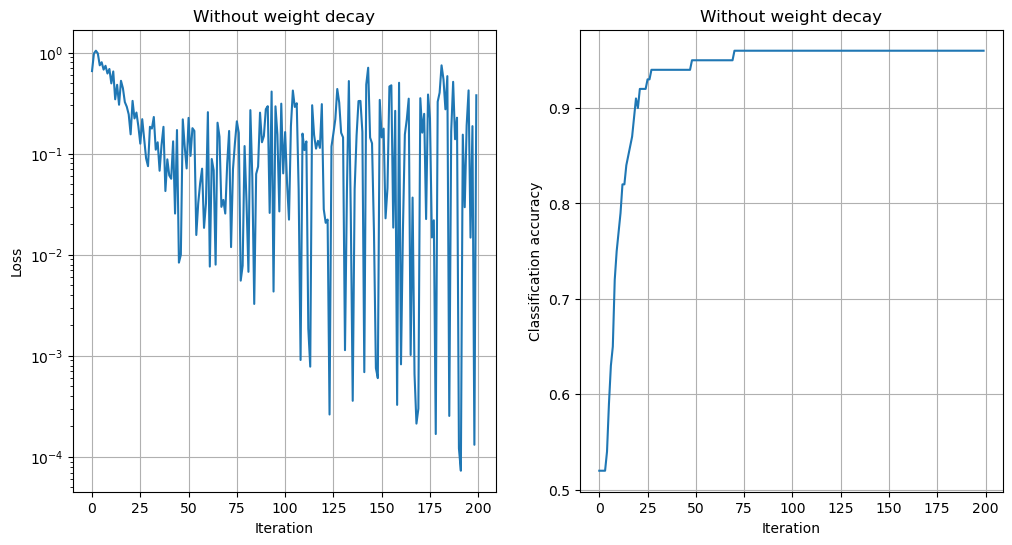

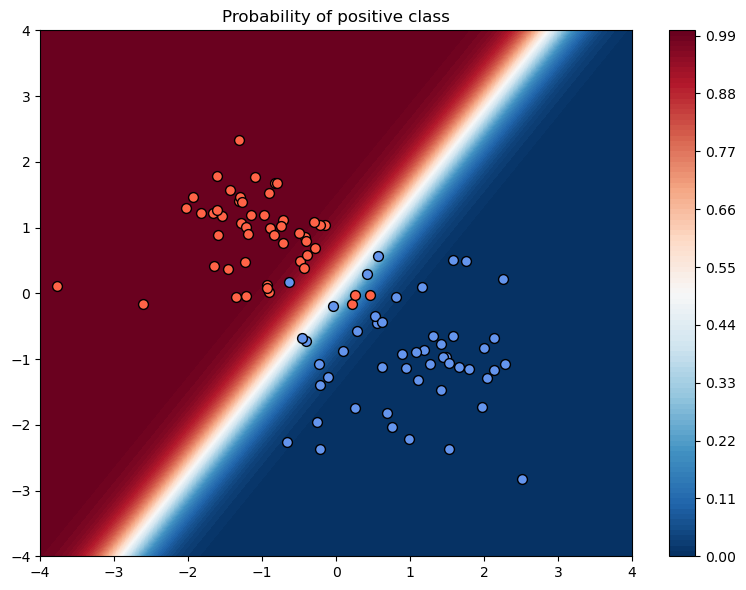

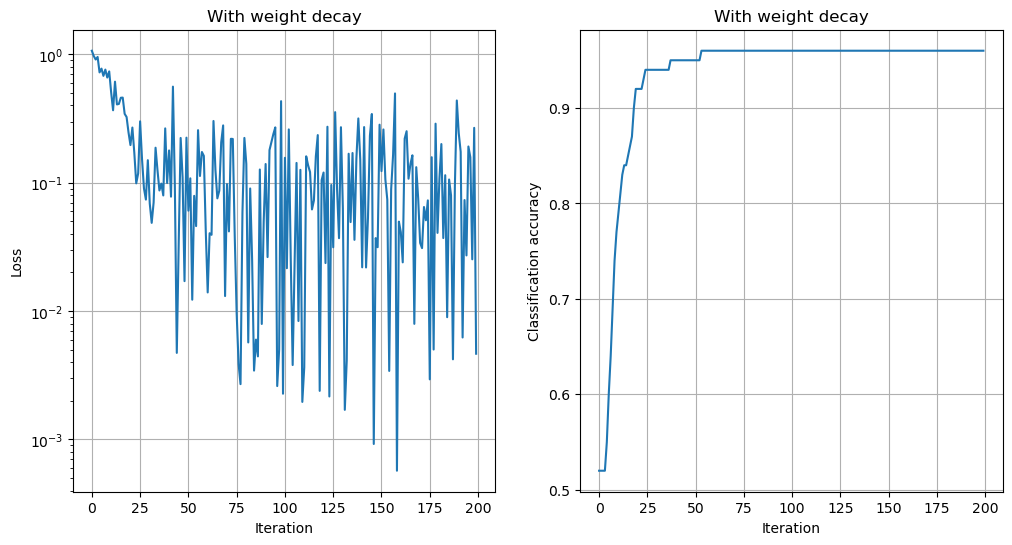

In [15]:
# Part b)
# loss function and optimizer
criterion = nn.BCELoss(reduction='mean') # binary cross-entropy loss, use mean loss
lr = 1e-2 # learning rate

# no weight decay
plot_probs = True
logreg_model = LogisticRegression(2)
optimizer = torch.optim.SGD(logreg_model.parameters(), lr=lr, momentum=0.99) 
# training loop
n_iter = 200
batch_size = 16
loss_values, accuracies = [], []
for n in range(n_iter):
    # zero out gradients
    optimizer.zero_grad()
    # sample random batch and pass to model
    batch_indices = np.random.choice(np.arange(len(labels)), size=batch_size)
    input_batch = input_data[batch_indices].unsqueeze(-1) # make dimensions match for matrix multiplication
    label_batch = labels[batch_indices]
    predictions = logreg_model(input_batch).squeeze(-1) # make dimensions match for loss function
    # calculate loss
    loss = criterion(predictions, label_batch)
    # backpropagate and update
    loss.backward()
    optimizer.step()
    # logging
    loss_values.append(loss.item())
    accuracies.append(model_accuracy(logreg_model, input_data, labels))
# plot model probabilities
if plot_probs:
    plot_model_probs(logreg_model, plus_class, negative_class)
    plt.savefig("./img/classification_no_weightdecay.png")
# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Without weight decay')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('Without weight decay')
plt.xlabel('Iteration')
plt.ylabel('Classification accuracy')
plt.savefig("./img/lossacc_no_weightdecay.png")

# with weight decay
plot_probs = True
logreg_model = LogisticRegression(2) # re-initialize model
optimizer = torch.optim.SGD(logreg_model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-2) 
# training loop
n_iter = 200
batch_size = 16
loss_values, accuracies = [], []
for n in range(n_iter):
    # zero out gradients
    optimizer.zero_grad()
    # sample random batch and pass to model
    batch_indices = np.random.choice(np.arange(len(labels)), size=batch_size)
    input_batch = input_data[batch_indices].unsqueeze(-1) # make dimensions match for matrix multiplication
    label_batch = labels[batch_indices]
    predictions = logreg_model(input_batch).squeeze(-1) # make dimensions match for loss function
    # calculate loss
    loss = criterion(predictions, label_batch)
    # backpropagate and update
    loss.backward()
    optimizer.step()
    # logging
    loss_values.append(loss.item())
    accuracies.append(model_accuracy(logreg_model, input_data, labels))
# plot model probabilities
if plot_probs:
    plot_model_probs(logreg_model, plus_class, negative_class)
    plt.savefig("./img/classification_w_weightdecay.png")
# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('With weight decay')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('With weight decay')
plt.xlabel('Iteration')
plt.ylabel('Classification accuracy')
plt.savefig("./img/lossacc_w_weightdecay.png")

<table>
    <tr>
        <td><img src="./img/classification_no_weightdecay.png" alt="Image 1" width="800"></td>
        <td><img src="./img/classification_w_weightdecay.png" alt="Image 2" width="800"></td>
    </tr>
    <tr>
        <td><img src="./img/lossacc_no_weightdecay.png" alt="Image 3" width="800"></td>
        <td><img src="./img/lossacc_w_weightdecay.png" alt="Image 4" width="800"></td>
    </tr>
</table>

## Exercise: Varying training parameters
In the above example, we chose a learning rate of $\alpha=10^{-2}$, used no momentum, used no weight decay, and trained the model for 200 iterations.

a) Compare the results of training with and without momentum, keeping the learning rate and number of iterations fixed.

**Setting**:
* $\mu=0.99$

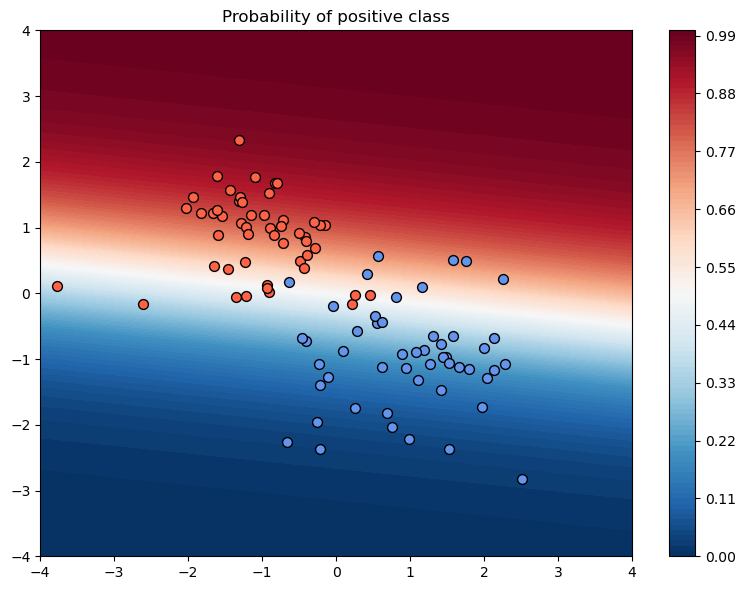

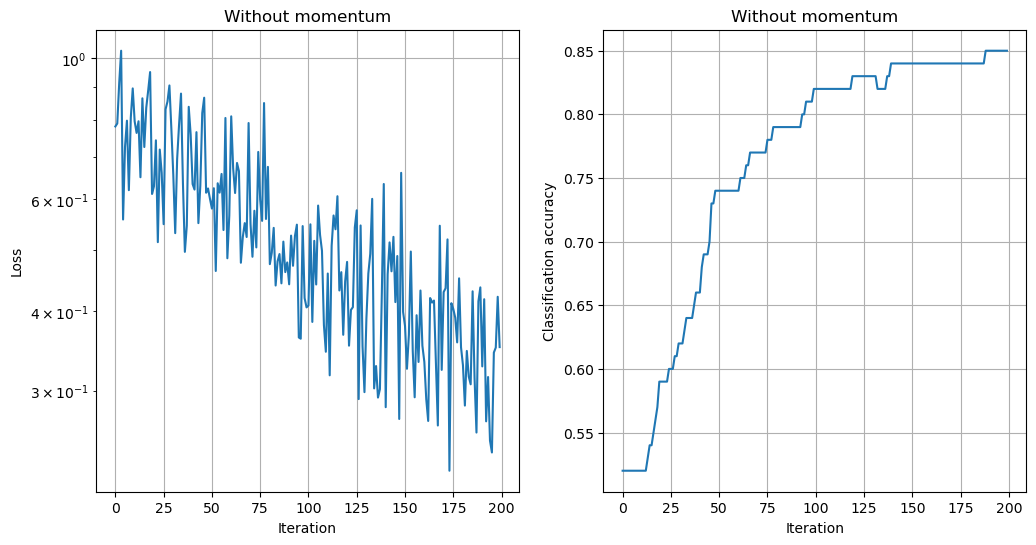

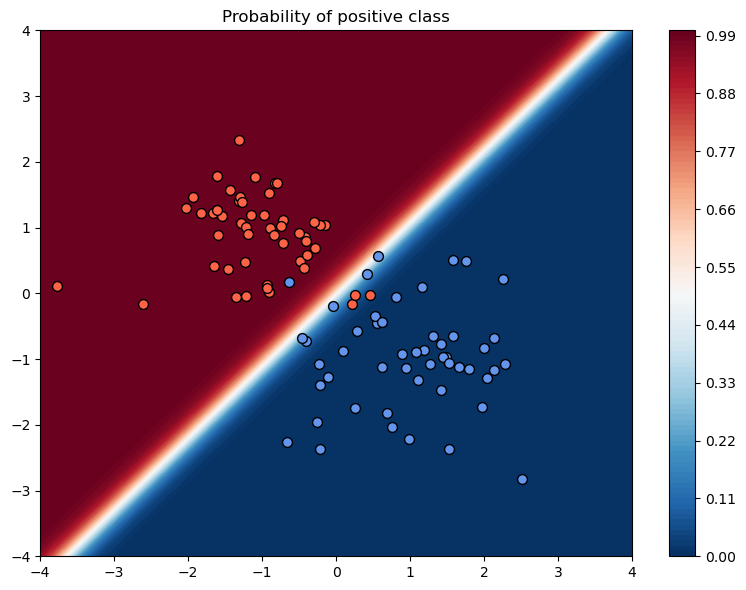

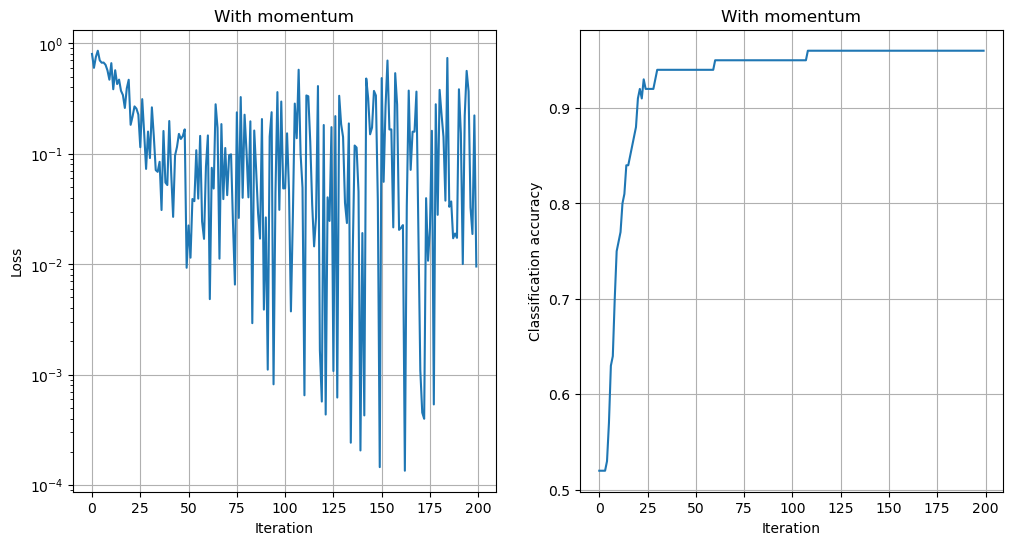

In [14]:
# Part a)
# loss function and optimizer
criterion = nn.BCELoss(reduction='mean') # binary cross-entropy loss, use mean loss
lr = 1e-2 # learning rate

# without momentum
plot_probs = True
logreg_model = LogisticRegression(2)
optimizer = torch.optim.SGD(logreg_model.parameters(), lr=lr) 
# training loop
n_iter = 200
batch_size = 16
loss_values, accuracies = [], []
for n in range(n_iter):
    # zero out gradients
    optimizer.zero_grad()
    # sample random batch and pass to model
    batch_indices = np.random.choice(np.arange(len(labels)), size=batch_size)
    input_batch = input_data[batch_indices].unsqueeze(-1) # make dimensions match for matrix multiplication
    label_batch = labels[batch_indices]
    predictions = logreg_model(input_batch).squeeze(-1) # make dimensions match for loss function
    # calculate loss
    loss = criterion(predictions, label_batch)
    # backpropagate and update
    loss.backward()
    optimizer.step()
    # logging
    loss_values.append(loss.item())
    accuracies.append(model_accuracy(logreg_model, input_data, labels))
# plot model probabilities
if plot_probs:
    plot_model_probs(logreg_model, plus_class, negative_class)
    plt.savefig("./img/classification_no_momentum.png")
# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('Without momentum')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('Without momentum')
plt.xlabel('Iteration')
plt.ylabel('Classification accuracy')
plt.savefig("./img/lossacc_no_momentum.png")


# with momentum
plot_probs = True
logreg_model = LogisticRegression(2) # re-initialize model
optimizer = torch.optim.SGD(logreg_model.parameters(), lr=lr, momentum=0.99) 
# training loop
n_iter = 200
batch_size = 16
loss_values, accuracies = [], []
for n in range(n_iter):
    # zero out gradients
    optimizer.zero_grad()
    # sample random batch and pass to model
    batch_indices = np.random.choice(np.arange(len(labels)), size=batch_size)
    input_batch = input_data[batch_indices].unsqueeze(-1) # make dimensions match for matrix multiplication
    label_batch = labels[batch_indices]
    predictions = logreg_model(input_batch).squeeze(-1) # make dimensions match for loss function
    # calculate loss
    loss = criterion(predictions, label_batch)
    # backpropagate and update
    loss.backward()
    optimizer.step()
    # logging
    loss_values.append(loss.item())
    accuracies.append(model_accuracy(logreg_model, input_data, labels))
# plot model probabilities
if plot_probs:
    plot_model_probs(logreg_model, plus_class, negative_class)
    plt.savefig("./img/classification_w_momentum.png")
# plot loss values
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.semilogy(loss_values)
plt.grid(True)
plt.title('With momentum')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.grid(True)
plt.title('With momentum')
plt.xlabel('Iteration')
plt.ylabel('Classification accuracy')
plt.savefig("./img/lossacc_w_momentum.png")

<table>
    <tr>
        <td><img src="./img/classification_no_momentum.png" alt="Image 1" width="800"></td>
        <td><img src="./img/classification_w_momentum.png" alt="Image 2" width="800"></td>
    </tr>
    <tr>
        <td><img src="./img/lossacc_no_momentum.png" alt="Image 3" width="800"></td>
        <td><img src="./img/lossacc_w_momentum.png" alt="Image 4" width="800"></td>
    </tr>
</table>

**Observations**:
* The loss values are lower and the accuracy improves faster to the best possible accuracy.

## That's it for today

- Have a good weekend
- HW5 due Monday
- With talk about PyTorch Dataset management Tuesdayy